# Exploratory Data Analysis (EDA) Distribuido para ML en Spark/Cluster
Este notebook realiza un EDA eficiente y escalable usando PySpark y librerías distribuidas como Vaex y Modin, ideales para grandes volúmenes de datos en clústeres Spark/Hadoop.

In [1]:
# Inicializar SparkSession
from pyspark.sql import SparkSession
import os
import matplotlib.pyplot as plt
import seaborn as sns
spark = SparkSession.builder.appName("US_Accidents_EDA").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/02 03:20:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Cargar el dataset en Spark DataFrame
df = spark.read.option("header", True).option("inferSchema", True).csv("/kaggle/input/muestra-accidents/muestra.csv")
df.cache()
df.show(5)

25/06/02 03:21:14 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------+-------+--------+-------------------+-------------------+------------------+----------+------------------+------------------+------------+--------------------+------------+------------+-----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|       ID| Source|Severity|         Start_Time|           End_Time|         Start_Lat| Start_Lng|           End_Lat|           End_Lng|Distance(mi)|         Description|      Street|        City|     County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation

In [3]:
# Dimensiones y tipos de datos
df.printSchema()
print(f"Filas: {df.count()}, Columnas: {len(df.columns)}")

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- V

In [4]:
# Estadísticas descriptivas
df.describe().show()

+-------+--------+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+-----------------+----------+---------+------+------------------+-------+----------+------------+------------------+-----------------+------------------+------------------+-----------------+--------------+-----------------+--------------------+------------------+--------------+--------------+-----------------+---------------------+
|summary|      ID| Source|           Severity|        Start_Lat|         Start_Lng|           End_Lat|           End_Lng|      Distance(mi)|         Description|           Street|      City|   County| State|           Zipcode|Country|  Timezone|Airport_Code|    Temperature(F)|    Wind_Chill(F)|       Humidity(%)|      Pressure(in)|   Visibility(mi)|Wind_Direction|  Wind_Speed(mph)|   Precipitation(in)| Weather_Condition|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|
+-------+-

## Estadísticas descriptivas y distribución de la variable objetivo

In [5]:
# Estadísticas descriptivas de variables numéricas
num_features = [field.name for field in df.schema.fields if field.dataType.typeName() in ['integer', 'double']]
df.select(num_features).describe().show()

+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+--------------------+
|summary|           Severity|        Start_Lat|         Start_Lng|           End_Lat|           End_Lng|      Distance(mi)|    Temperature(F)|    Wind_Chill(F)|       Humidity(%)|      Pressure(in)|   Visibility(mi)|  Wind_Speed(mph)|   Precipitation(in)|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+--------------------+
|  count|             800000|           800000|            800000|            447542|            447542|            800000|            782950|           592759|            781839|            785293|           781529|           74088

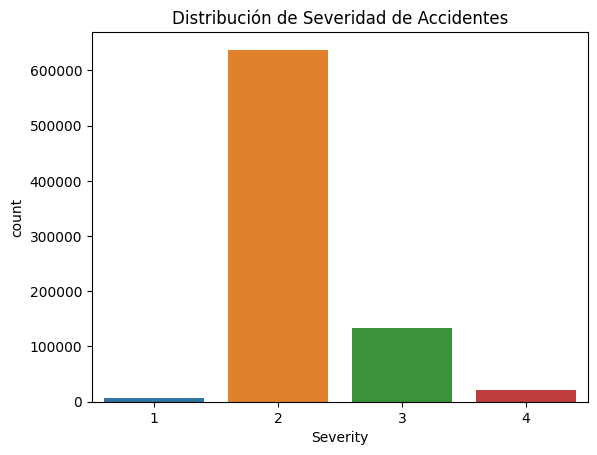

In [6]:
# Conteo de severidad de accidentes (distribución de la variable objetivo)
severity_pd = df.groupBy('Severity').count().orderBy('Severity').toPandas()
sns.barplot(x='Severity', y='count', data=severity_pd)
plt.title('Distribución de Severidad de Accidentes')
plt.show()

# Limpieza de valores nulos y preparacion de datos


In [7]:
from pyspark.sql.functions import col, count, when, lit, to_timestamp

# Eliminar columnas con demasiados nulos
cols_to_drop = [
    'End_Lat', 'End_Lng', 'Precipitation(in)', 'Wind_Chill(F)', 'Airport_Code'
]
df = df.drop(*cols_to_drop)

# Imputar columnas numéricas con la mediana
def impute_median(df, cols):
    for col_name in cols:
        median_val = df.approxQuantile(col_name, [0.5], 0.01)[0] if col_name in df.columns else None
        if median_val is not None:
            df = df.withColumn(col_name, when(col(col_name).isNull(), lit(median_val)).otherwise(col(col_name)))
    return df

num_cols = [
    'Wind_Speed(mph)', 'Visibility(mi)', 'Humidity(%)', 'Temperature(F)', 'Pressure(in)'
]
df = impute_median(df, num_cols)

# Imputar columnas categóricas con la moda
from pyspark.sql import functions as F

def impute_mode(df, cols):
    for col_name in cols:
        if col_name in df.columns:
            mode_row = df.groupBy(col_name).count().orderBy(F.desc('count')).first()
            mode_val = mode_row[0] if mode_row else 'Unknown'
            df = df.withColumn(col_name, when(col(col_name).isNull(), lit(mode_val)).otherwise(col(col_name)))
    return df

cat_cols = [
    'Weather_Condition', 'Wind_Direction',
    'Nautical_Twilight', 'Civil_Twilight', 'Sunrise_Sunset', 'Astronomical_Twilight',
    'Street', 'Timezone', 'Zipcode', 'City'
]
df = impute_mode(df, cat_cols)

# Verificar que no queden nulos 
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+------+--------+----------+--------+---------+---------+------------+-----------+------+----+------+-----+-------+-------+--------+-----------------+--------------+-----------+------------+--------------+--------------+---------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID|Source|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|Distance(mi)|Description|Street|City|County|State|Zipcode|Country|Timezone|Weather_Timestamp|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|
+---+------+--------+----------+--------+---------+---------+------------+-----------+------+-

In [8]:
# Imputación de nulos en columnas de fecha con la mediana o valor fijo si la columna es nula

from pyspark.sql.functions import col, when, lit, to_timestamp, unix_timestamp

def impute_datetime_median_spark(df, cols):
    for col_name in cols:
        if col_name in df.columns:
            # Convertir a timestamp si es necesario
            df = df.withColumn(col_name, to_timestamp(col(col_name)))
            # Convertir a long 
            df = df.withColumn(col_name + '_long', unix_timestamp(col(col_name)))
            notnull_count = df.filter(col(col_name + '_long').isNotNull()).count()
            if notnull_count > 0:
                median_val = df.approxQuantile(col_name + '_long', [0.5], 0.01)[0]
                df = df.withColumn(
                    col_name + '_long',
                    when(col(col_name + '_long').isNull(), lit(median_val)).otherwise(col(col_name + '_long'))
                )
                # Volver a timestamp
                df = df.withColumn(col_name, (col(col_name + '_long')).cast('timestamp'))
            else:
                df = df.withColumn(
                    col_name,
                    when(col(col_name).isNull(), lit('1970-01-01 00:00:00')).otherwise(col(col_name))
                )
            # Eliminar columna auxiliar
            df = df.drop(col_name + '_long')
    return df

fecha_cols = ['Start_Time', 'End_Time', 'Weather_Timestamp']
df = impute_datetime_median_spark(df, fecha_cols)

# Verificar que no queden nulos en fechas
df.select([F.count(F.when(col(c).isNull(), c)).alias(c) for c in fecha_cols]).show()

+----------+--------+-----------------+
|Start_Time|End_Time|Weather_Timestamp|
+----------+--------+-----------------+
|         0|       0|                0|
+----------+--------+-----------------+



# Visualización de EDA distribuido: Graficar resultados agregados de Spark
Para visualizar los resultados de Spark, exportamos muestras o agregados a pandas y graficamos con matplotlib/seaborn. Esto permite análisis visual incluso en entornos distribuidos.

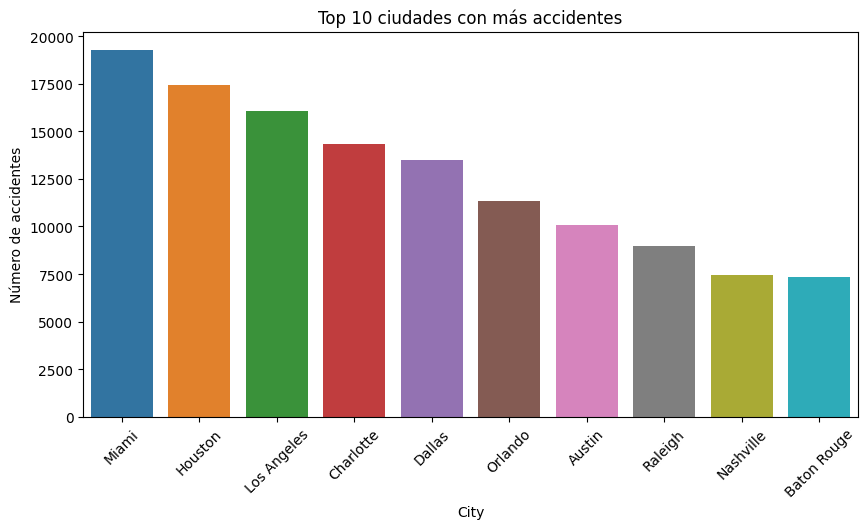

In [9]:
# Top 10 ciudades con más accidentes
city_pd = df.groupBy('City').count().orderBy('count', ascending=False).limit(10).toPandas()
plt.figure(figsize=(10, 5))
sns.barplot(x='City', y='count', data=city_pd)
plt.title('Top 10 ciudades con más accidentes')
plt.ylabel('Número de accidentes')
plt.xticks(rotation=45)
plt.show()

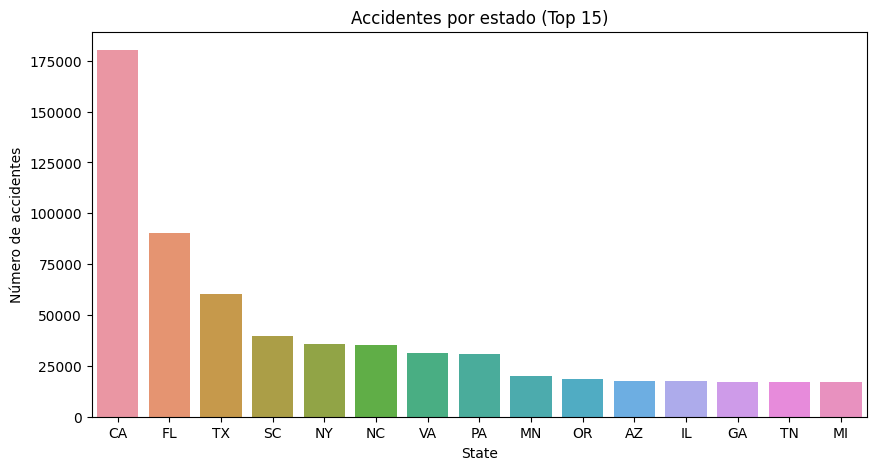

In [10]:
# Top 15 estados con más accidentes
state_pd = df.groupBy('State').count().orderBy('count', ascending=False).limit(15).toPandas()
plt.figure(figsize=(10, 5))
sns.barplot(x='State', y='count', data=state_pd)
plt.title('Accidentes por estado (Top 15)')
plt.ylabel('Número de accidentes')
plt.show()

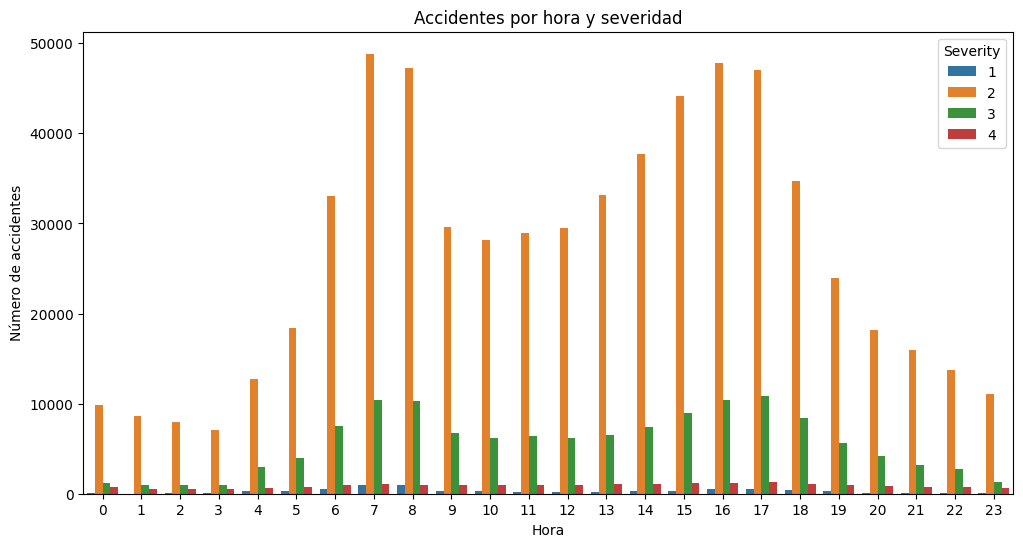

In [11]:
# Distribución de accidentes por franja horaria
from pyspark.sql.functions import hour, col
if 'Start_Time' in df.columns:
    df = df.withColumn('hour', hour(col('Start_Time')))
    hour_pd = df.groupBy('hour', 'Severity').count().orderBy('hour', 'Severity').toPandas()
    plt.figure(figsize=(12, 6))
    sns.barplot(x='hour', y='count', hue='Severity', data=hour_pd)
    plt.title('Accidentes por hora y severidad')
    plt.xlabel('Hora')
    plt.ylabel('Número de accidentes')
    plt.show()

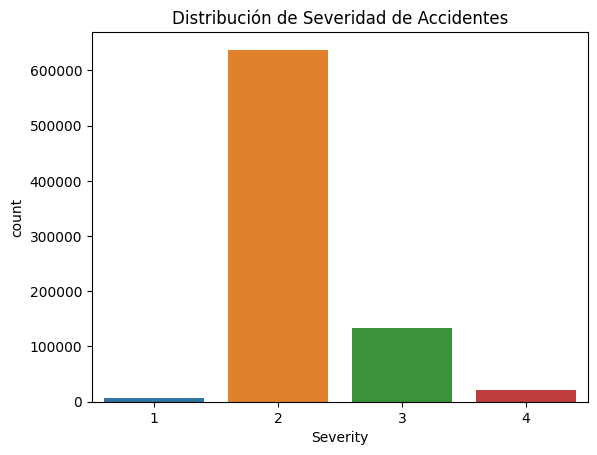

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ejemplo: Gráfico de barras de la distribución de severidad
severity_pd = df.groupBy('Severity').count().orderBy('Severity').toPandas()
sns.barplot(x='Severity', y='count', data=severity_pd)
plt.title('Distribución de Severidad de Accidentes')
plt.show()

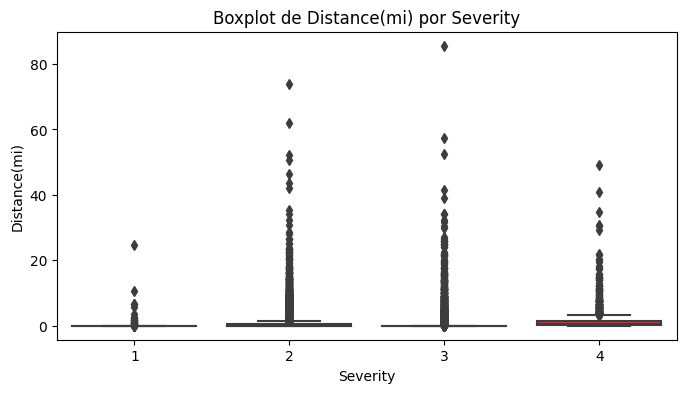

In [13]:
# Para un boxplot real (con una muestra pequeña)
sample_df = df.select('Severity', 'Distance(mi)').sample(fraction=0.1, seed=42).toPandas()
plt.figure(figsize=(8, 4))
sns.boxplot(x='Severity', y='Distance(mi)', data=sample_df)
plt.title('Boxplot de Distance(mi) por Severity')
plt.ylabel('Distance(mi)')
plt.show()

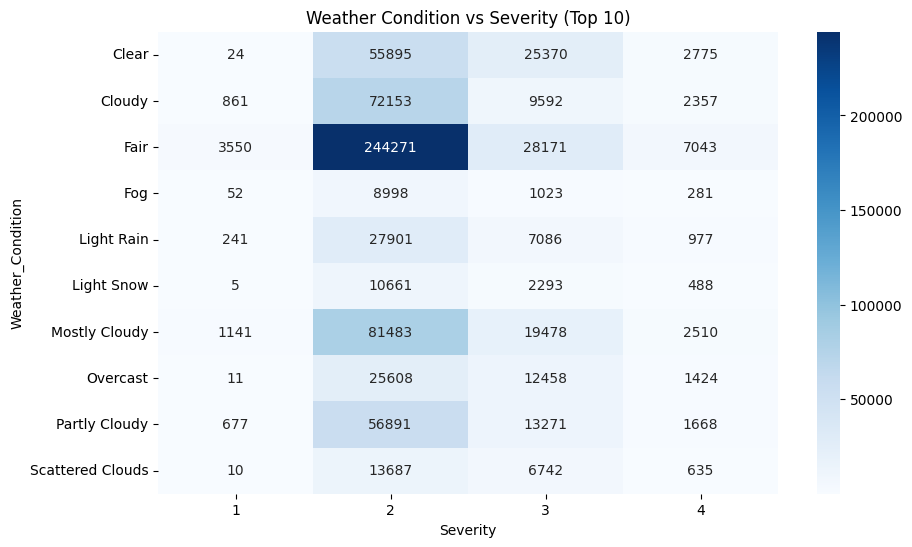

In [14]:
# Heatmap de Weather_Condition vs Severity (Top 10)
weather_pd = df.groupBy('Weather_Condition', 'Severity').count().toPandas()
top_weather = weather_pd.groupby('Weather_Condition')['count'].sum().nlargest(10).index
weather_pd = weather_pd[weather_pd['Weather_Condition'].isin(top_weather)]
weather_pivot = weather_pd.pivot(index='Weather_Condition', columns='Severity', values='count').fillna(0)
plt.figure(figsize=(10, 6))
sns.heatmap(weather_pivot, annot=True, fmt='.0f', cmap='Blues')
plt.title('Weather Condition vs Severity (Top 10)')
plt.ylabel('Weather_Condition')
plt.xlabel('Severity')
plt.show()

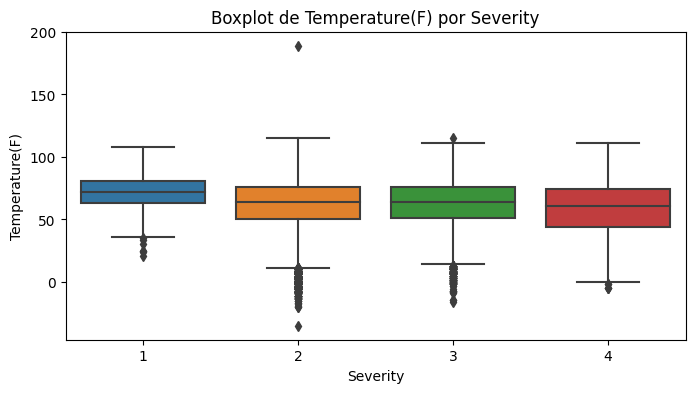

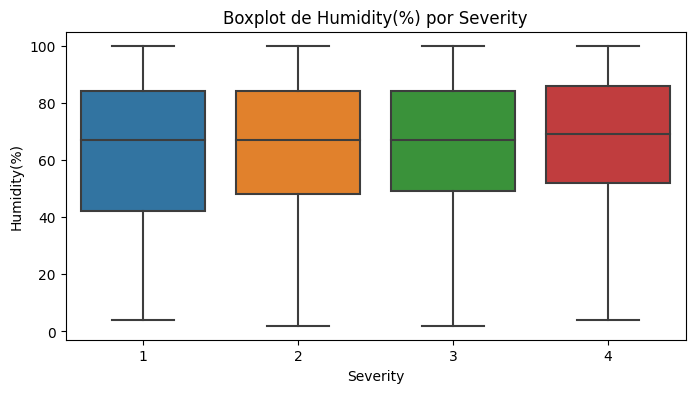

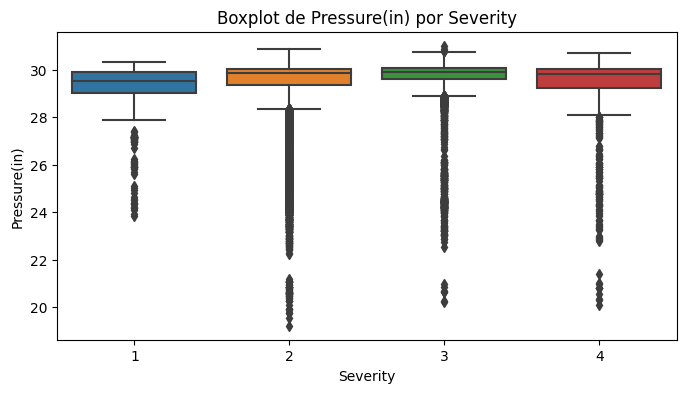

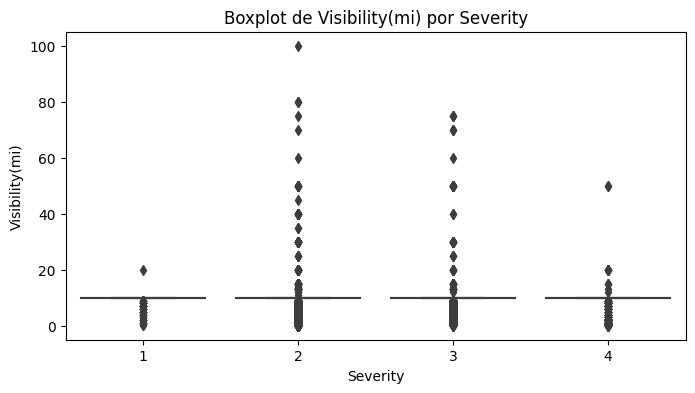

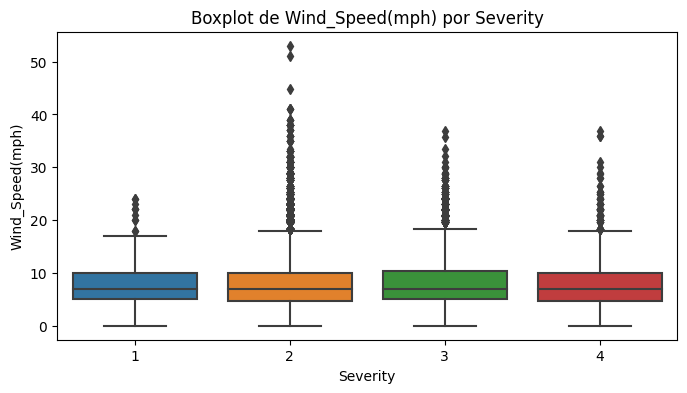

In [15]:
from pyspark.sql.functions import col

for col_name in ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']:
    # Tomar una muestra para no cargar todo el dataset a memoria
    sample_pd = (
        df.select('Severity', col_name)
          .sample(fraction=0.1, seed=42)
          .toPandas()
    )
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='Severity', y=col_name, data=sample_pd)
    plt.title(f'Boxplot de {col_name} por Severity')
    plt.ylabel(col_name)
    plt.show()

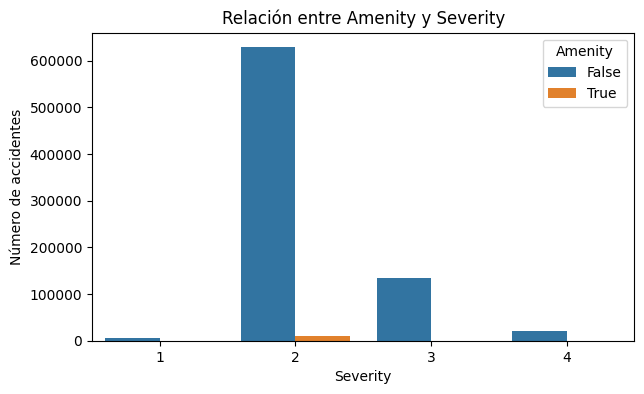

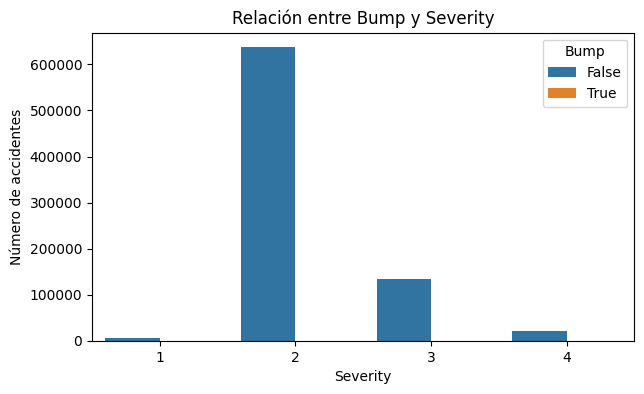

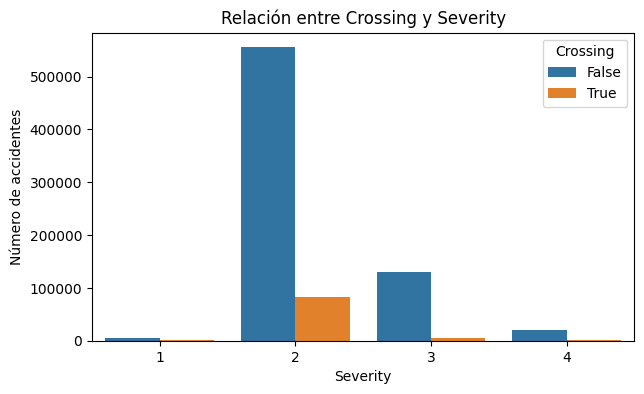

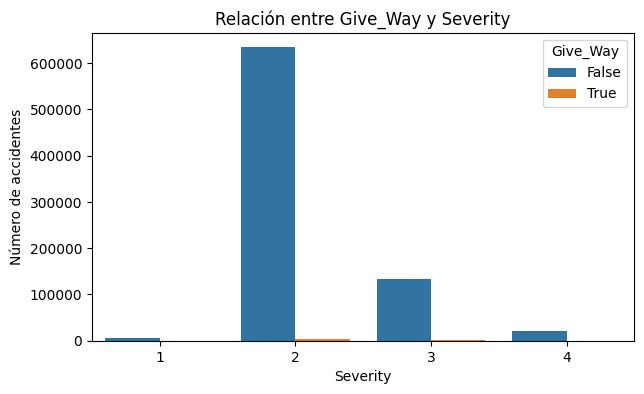

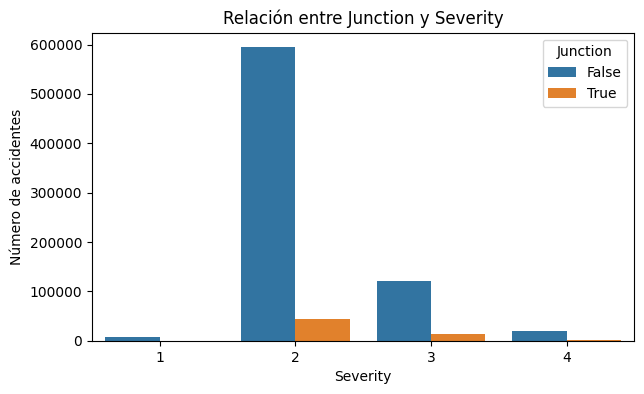

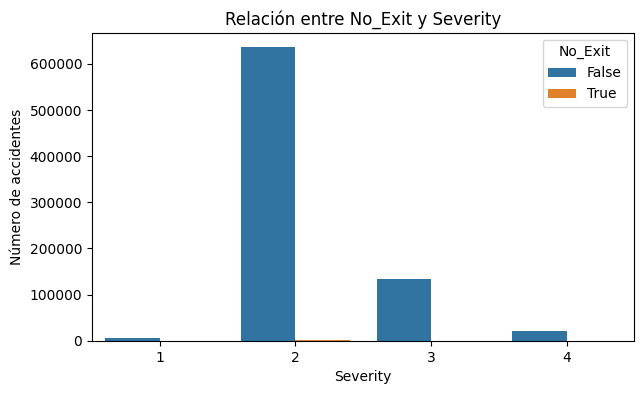

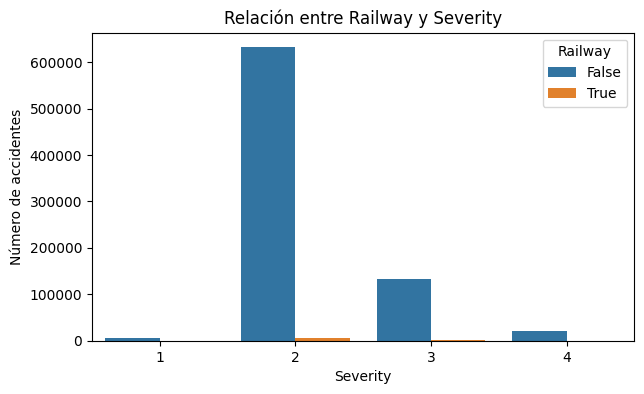

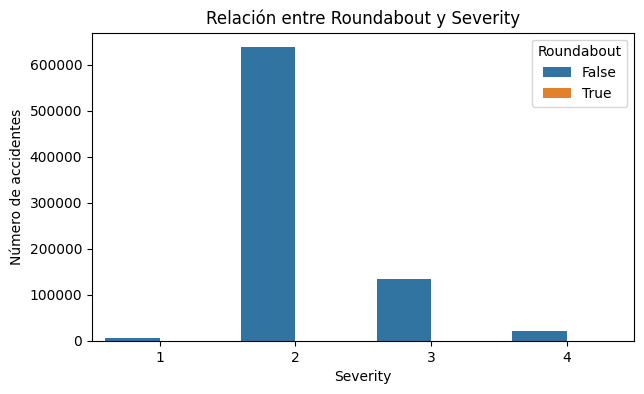

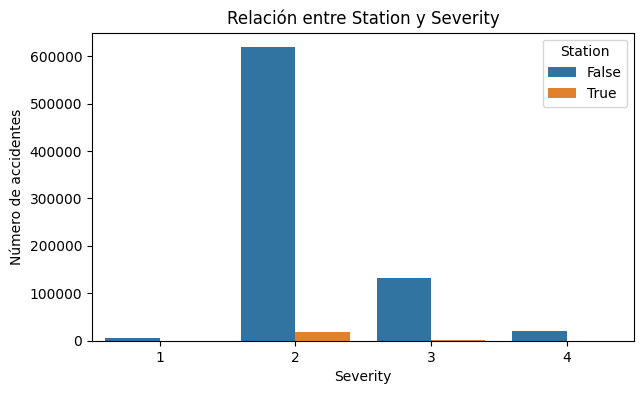

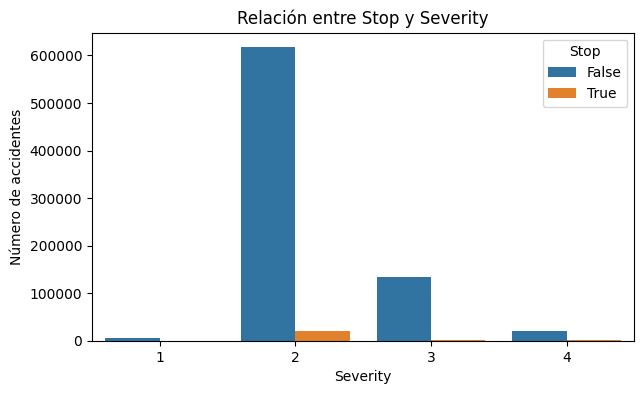

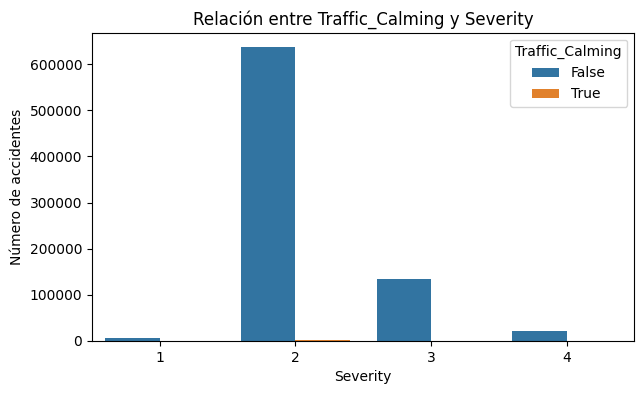

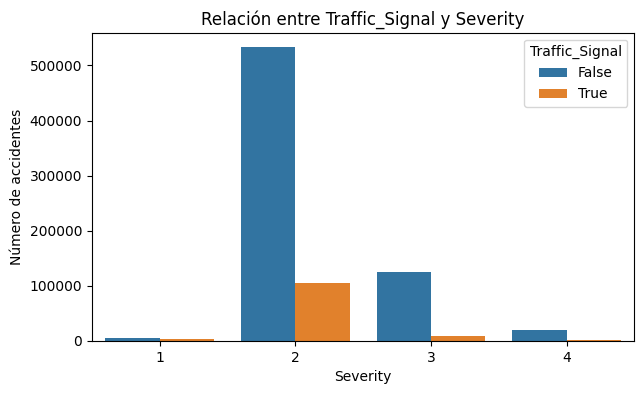

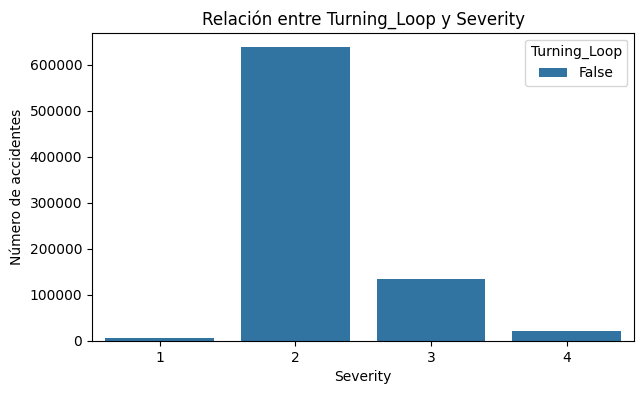

In [16]:
bool_vars = [
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
    'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
    'Traffic_Signal', 'Turning_Loop'
]

for col_name in bool_vars:
    if col_name in df.columns:
        # Agrupa y cuenta por valor booleano y severidad
        pd_df = (
            df.groupBy(col_name, 'Severity')
              .count()
              .orderBy(col_name, 'Severity')
              .toPandas()
        )
        plt.figure(figsize=(7, 4))
        sns.barplot(x='Severity', y='count', hue=col_name, data=pd_df)
        plt.title(f'Relación entre {col_name} y Severity')
        plt.ylabel('Número de accidentes')
        plt.show()

# Eliminación de filas con outliers extremos en columnas numéricas
Filtramos las filas que tienen valores mayores al percentil 99.5 en 'Distance(mi)', 'Wind_Speed(mph)' y 'Visibility(mi)' para mejorar la calidad del análisis y los modelos de ML.

In [17]:
cols_outliers = ['Distance(mi)', 'Wind_Speed(mph)', 'Visibility(mi)']
percentile = 0.95
from pyspark.sql import functions as F

for col in cols_outliers:
    if col in df.columns:
        upper = df.approxQuantile(col, [percentile], 0.01)[0]
        df = df.filter(F.col(col) <= upper)

print(f"Filas restantes tras eliminar outliers en {cols_outliers}: {df.count()}")

Filas restantes tras eliminar outliers en ['Distance(mi)', 'Wind_Speed(mph)', 'Visibility(mi)']: 716640


# Feature Engineering sobre la columna 'Description'
La columna 'Description' contiene información textual sobre el accidente. Vamos a explorarla y extraer features útiles para modelos de ML.

In [18]:
# Frecuencia de descripciones
if 'Description' in df.columns:
    desc_pd = df.groupBy('Description').count().orderBy('count', ascending=False).toPandas()
    print(desc_pd.head(10))

                                         Description  count
0  A crash has occurred causing no to minimum del...    841
1                                           Accident    720
2  An unconfirmed report of a crash has been rece...    313
3  A crash has occurred with minimal delay to tra...    258
4                  A crash has occurred use caution.    232
5                                 At I-5 - Accident.    216
6                                At I-15 - Accident.    209
7  A disabled vehicle is creating a hazard causin...    181
8  Incident on I-95 NB near I-95 Drive with caution.    172
9                 At I-405/San Diego Fwy - Accident.    168


In [19]:
# Limpieza básica de texto: minúsculas, quitar signos de puntuación
from pyspark.sql.functions import lower, regexp_replace, length
if 'Description' in df.columns:
    df = df.withColumn('Description_clean', lower(regexp_replace('Description', '[^a-zA-Z0-9 ]', '')))

In [ ]:
# Tokenización de palabras clave
from pyspark.ml.feature import Tokenizer
if 'Description_clean' in df.columns:
    tokenizer = Tokenizer(inputCol="Description_clean", outputCol="Description_tokens")
    df = tokenizer.transform(df)
    tokens_pd = df.select('Description_tokens').limit(10000).toPandas()
    from collections import Counter
    import itertools
    all_tokens = list(itertools.chain.from_iterable(tokens_pd['Description_tokens']))
    word_freq = Counter(all_tokens)
    print(word_freq.most_common(20))
    from wordcloud import WordCloud
    wc = WordCloud(width=800, height=400).generate_from_frequencies(word_freq)
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

[('on', 8066), ('accident', 7332), ('to', 5522), ('at', 4922), ('due', 3522), ('rd', 3362), ('', 2543), ('blocked', 2325), ('near', 2292), ('st', 2134), ('ave', 2058), ('incident', 1930), ('from', 1887), ('lane', 1805), ('exit', 1787), ('traffic', 1484), ('caution', 1235), ('with', 1196), ('drive', 1188), ('blvd', 1065)]


In [21]:
# Features simples: longitud, número de palabras, presencia de palabras clave
from pyspark.sql.functions import size
if 'Description_clean' in df.columns and 'Description_tokens' in df.columns:
    df = df.withColumn('desc_length', length('Description_clean'))
    df = df.withColumn('desc_num_words', size('Description_tokens'))
    from pyspark.sql.functions import array_contains, lit
    df = df.withColumn('desc_has_accident', array_contains('Description_tokens', lit('accident')))

In [22]:
# Vectorización básica: TF y TF-IDF
from pyspark.ml.feature import CountVectorizer, IDF
if 'Description_tokens' in df.columns:
    cv = CountVectorizer(inputCol="Description_tokens", outputCol="desc_tf", vocabSize=1000, minDF=5)
    cv_model = cv.fit(df)
    df = cv_model.transform(df)
    idf = IDF(inputCol="desc_tf", outputCol="desc_tfidf")
    idf_model = idf.fit(df)
    df = idf_model.transform(df)


# Feature Engineering y Pipeline de Preparación de Datos para ML en Spark

Implementación el pipeline de preparación de datos para clasificación de severidad, adaptando el flujo de Kaggle y usando PySpark, con ranking manual de Weather_Condition.

In [24]:
# Selección de features relevantes
features_finales = [
    'Distance(mi)', 'Precipitation(in)',
    'Weather_Condition', 'State', 'hour', 'weekday',
    'Sunrise_Sunset', 'Traffic_Signal', 'Crossing',
    'desc_length', 'desc_num_words', 'desc_has_accident', 'Severity', 'desc_tf',
 'desc_tfidf', 'Junction'
]
features_finales = [col for col in features_finales if col in df.columns]
df_ml = df.select(*features_finales)

In [25]:
# Ranking manual de Weather_Condition con ranking único por condición
from pyspark.sql.functions import monotonically_increasing_id

# Obtener lista única de condiciones
weather_conditions = df_ml.select('Weather_Condition').distinct().rdd.flatMap(lambda x: x).collect()
weather_conditions = sorted(weather_conditions)

very_good = [
    'Clear', 'Fair', 'Fair / Windy', 'Mostly Clear', 'Sunny', 'Partly Cloudy', 'Partly Cloudy / Windy',
    'Mostly Sunny', 'Scattered Clouds'
]
good = [
    'Mostly Cloudy', 'Cloudy', 'Overcast', 'Overcast / Windy', 'Cloudy / Windy',
    'Haze', 'Smoke'
]
moderate = [
    'Light Rain', 'Rain Showers', 'Rain', 'Showers', 'Drizzle', 'Sprinkles',
    'Light Rain / Windy', 'Rain / Windy', 'Light Drizzle',
    'Light Freezing Rain', 'Light Snow Grains', 'Light Freezing Drizzle'
]
bad = [
    'Heavy Rain', 'Heavy Rain / Windy', 'Rain Shower', 'Thunderstorms', 'Thunderstorm',
    'Thunderstorms and Rain', 'Light Thunderstorms and Rain',
    'Fog', 'Fog / Windy', 'Mist', 'Patches of Fog', 'Shallow Fog',
    'Blowing Dust', 'Widespread Dust', 'Volcanic Ash'
]
very_bad = [
    'Snow', 'Light Snow', 'Heavy Snow', 'Snow Showers', 'Blowing Snow',
    'Freezing Rain', 'Freezing Drizzle', 'Ice Pellets', 'Sleet', 'Hail',
    'Snow Grains', 'Small Hail', 'Freezing Fog', 'Heavy Freezing Rain',
    'Heavy Thunderstorms and Rain', 'Unknown', 'Duststorm', 'Sandstorm'
]

# Crear ranking único por condición
ranking = {}
rank = 0
for group in [very_good, good, moderate, bad, very_bad]:
    for cond in group:
        ranking[cond] = rank
        rank += 1
remaining_conditions = [cond for cond in weather_conditions if cond not in ranking]
for cond in remaining_conditions:
    ranking[cond] = rank
    rank += 1

# Crear un DataFrame de mapeo para Spark
import pandas as pd
ranking_pd = pd.DataFrame(list(ranking.items()), columns=['Weather_Condition', 'Weather_Condition_rank'])
ranking_spark = spark.createDataFrame(ranking_pd)

# Hacer join para asignar el ranking único
from pyspark.sql.functions import coalesce

df_ml = df_ml.join(ranking_spark, on='Weather_Condition', how='left')
df_ml = df_ml.drop('Weather_Condition')

In [26]:
# Encoding de variables categóricas restantes (StringIndexer + OneHotEncoder)
from pyspark.sql.functions import col

# Convertir columnas booleanas a string
for c in ['Traffic_Signal', 'Crossing', 'Junction']:
    if c in df_ml.columns and dict(df_ml.dtypes)[c] == 'boolean':
        df_ml = df_ml.withColumn(c, col(c).cast('string'))

from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
cat_vars = ['State', 'hour', 'weekday', 'Sunrise_Sunset', 'Traffic_Signal', 'Crossing', 'Junction']
cat_vars = [col for col in cat_vars if col in df_ml.columns]
indexers = [StringIndexer(inputCol=col, outputCol=col+"_idx", handleInvalid="keep") for col in cat_vars]
encoders = [OneHotEncoder(inputCol=col+"_idx", outputCol=col+"_ohe") for col in cat_vars]
pipeline = Pipeline(stages=indexers + encoders)
df_ml = pipeline.fit(df_ml).transform(df_ml)

In [27]:
# Estandarización de variables numéricas
from pyspark.ml.feature import StandardScaler, VectorAssembler
num_vars = ['Distance(mi)', 'desc_length', 'desc_num_words']
num_vars = [col for col in num_vars if col in df_ml.columns]
assembler_num = VectorAssembler(inputCols=num_vars, outputCol="num_features")
df_ml = assembler_num.transform(df_ml)
scaler = StandardScaler(inputCol="num_features", outputCol="num_features_scaled")
df_ml = scaler.fit(df_ml).transform(df_ml)

In [28]:
# Incorporar features de texto TF-IDF
from pyspark.ml.feature import VectorSlicer
n_features_tfidf = 200  
tfidf_col = 'desc_tfidf'
if tfidf_col in df_ml.columns:
    slicer = VectorSlicer(inputCol=tfidf_col, outputCol="desc_tfidf_sliced", indices=list(range(n_features_tfidf)))
    df_ml = slicer.transform(df_ml)

In [29]:
# Ensamblado final de todas las características para ML
from pyspark.ml.feature import VectorAssembler

# Seleccionar columnas transformadas para el vector final
feature_cols = [
    "num_features_scaled",  # Variables numéricas escaladas
    "State_ohe", "hour_ohe", "Sunrise_Sunset_ohe", 
    "Traffic_Signal_ohe", "Crossing_ohe", "Junction_ohe",  # Variables categóricas codificadas
    "desc_tfidf_sliced",  # Variables de texto procesadas
    "Weather_Condition_rank",  # Ranking numérico
    "desc_has_accident"  # Booleano convertido a numérico
]

# Verificar que todas las columnas existen en el DataFrame
feature_cols = [col for col in feature_cols if col in df_ml.columns]

# Ensamblar todas las características en un único vector
assembler_final = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="keep")
df_ml_final = assembler_final.transform(df_ml)

# Seleccionar solo las columnas necesarias para ML
df_ml_final = df_ml_final.select("features", "Severity")

# Mostrar el resultado final
df_ml_final.show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|features                                                                                                                                                                                                                                                                                                                                                         |Severity|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# División train/test (randomSplit, no estratifica)
#train_df, test_df = df_ml_final.randomSplit([0.8, 0.2], seed=42)
#print('Train count:', train_df.count(), 'Test count:', test_df.count())

In [30]:
# Train-test split estratificado para mantener distribución de Severity

train_dfs = []
test_dfs = []

# Para cada nivel de severidad
for severity in df_ml_final.select("Severity").distinct().collect():
    severity_value = severity["Severity"]
    
    # Filtrar datos para este nivel
    severity_df = df_ml_final.filter(col("Severity") == severity_value)
    
    # Dividir los datos de este nivel
    severity_train, severity_test = severity_df.randomSplit([0.8, 0.2], seed=42)
    
    train_dfs.append(severity_train)
    test_dfs.append(severity_test)

# Unir todos los DataFrames
train_df = train_dfs[0]
test_df = test_dfs[0]

for i in range(1, len(train_dfs)):
    train_df = train_df.unionByName(train_dfs[i])
    test_df = test_df.unionByName(test_dfs[i])

print('Train count:', train_df.count(), 'Test count:', test_df.count())

Train count: 573420 Test count: 143220


In [31]:
#Guardar el dataframe completo con todas las transformaciones
#train_df.write.mode('overwrite').parquet('/kaggle/working/train_ml_full.parquet')
#test_df.write.mode('overwrite').parquet('/kaggle/working/test_ml_full.parquet')

# Crear versión ML-ready con vectores expandidos para usarlo en otras plataformas para machine learning
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, DoubleType

# Extraer características del vector "features" a columnas individuales
def extract_features(df, vector_col, prefix):
    # Función para convertir un vector a array
    @udf(returnType=ArrayType(DoubleType()))
    def vector_to_array(v):
        return v.toArray().tolist() if v else None
    
    # Convertir vector a array
    df = df.withColumn(f"{vector_col}_array", vector_to_array(col(vector_col)))
    
    # Obtener la longitud del vector usando la primera fila
    vector_length = df.select(F.size(f"{vector_col}_array")).first()[0]
    
    # Crear columnas individuales para cada elemento del vector
    for i in range(vector_length):
        df = df.withColumn(f"{prefix}_{i}", col(f"{vector_col}_array")[i])
    
    return df.drop(f"{vector_col}_array")

# Procesar train y test
train_expanded = extract_features(train_df, "features", "feature")
test_expanded = extract_features(test_df, "features", "feature")
train_expanded = train_expanded.drop("features")
test_expanded = test_expanded.drop("features")

# Guardar versión expandida
train_expanded.write.mode('overwrite').option("header", True).parquet('/kaggle/working/train_ml_ready.parquet')
test_expanded.write.mode('overwrite').option("header", True).parquet('/kaggle/working/test_ml_ready.parquet')

# Guardamos en csv también
train_expanded.write.mode('overwrite').option("header", True).csv('/kaggle/working/train_ml_ready.csv')
test_expanded.write.mode('overwrite').option("header", True).csv('/kaggle/working/test_ml_ready.csv')

25/06/02 03:46:35 WARN DAGScheduler: Broadcasting large task binary with size 1001.2 KiB            
25/06/02 03:48:50 WARN DAGScheduler: Broadcasting large task binary with size 1001.2 KiB(3 + 1) / 4]


In [33]:

import glob

# Leer partes CSV (si fueran partes realmente)
csv_parts = glob.glob('/kaggle/working/test_ml_ready.csv/part-*.csv')
csv_parts_train = glob.glob('/kaggle/working/train_ml_ready.csv/part-*.csv')

# Leer partes PARQUET (si fueran carpetas con partes)
parquet_parts = glob.glob('/kaggle/working/test_ml_ready.parquet/part-*.parquet')
parquet_parts_train = glob.glob('/kaggle/working/train_ml_ready.parquet/part-*.parquet')

# Verificar si hay partes, de lo contrario leer directamente los archivos
if csv_parts:
    df_test = pd.concat([pd.read_csv(f) for f in csv_parts])
else:
    df_test = pd.read_csv('/kaggle/working/test_ml_ready.csv')

if csv_parts_train:
    df_train = pd.concat([pd.read_csv(f) for f in csv_parts_train])
else:
    df_train = pd.read_csv('/kaggle/working/train_ml_ready.csv')

if parquet_parts:
    pq_df_test = pd.concat([pd.read_parquet(f) for f in parquet_parts])
else:
    pq_df_test = pd.read_parquet('/kaggle/working/test_ml_ready.parquet')

if parquet_parts_train:
    pq_df_train = pd.concat([pd.read_parquet(f) for f in parquet_parts_train])
else:
    pq_df_train = pd.read_parquet('/kaggle/working/train_ml_ready.parquet')

# Guardar como archivos unidos
df_test.to_csv('/kaggle/working/test_ml_ready_unido.csv', index=False)
df_train.to_csv('/kaggle/working/train_ml_ready_unido.csv', index=False)
pq_df_test.to_parquet('/kaggle/working/test_ml_ready_unido.parquet')
pq_df_train.to_parquet('/kaggle/working/train_ml_ready_unido.parquet')

In [ ]:
from IPython.display import FileLink, display

files = [
    'train_ml_ready.csv',
    'train_ml_ready.parquet',
    'test_ml_ready.csv',
    'test_ml_ready.parquet'
]

for file in files:
    display(FileLink(f'/kaggle/working/{file}'))